# Prediction of AAPL stock using LR with ARMA errors (Until 2019)

## Content
0. [Download Data from Yahoo Finance](#section0)
1. [Data preparation (LOWESS smoother)](#section1)
2. [Exploratory Data Analysis](#section2)
3. [Data Testing](#section3)
4. [Fitting an ARMA model](#section4)
5. [Residual Analysis](#section5)
6. [Prediction vs. Realized Values](#section6)

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### <a id='section0'></a> 0 $\bullet$ Import Apple Stock data from 2010-01-04 to 2019-12-27

In [3]:
aapl_df = yf.download(tickers='AAPL', start='2010-01-04', end='2019-12-28', interval='1wk')
print(aapl_df.head())
print(aapl_df.tail())
print(aapl_df.shape[0])

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close        Volume
Date                                                                       
2010-01-01  7.622500  7.699643  7.466071  7.520714   6.467082  2.124926e+09
2010-01-08  7.510714  7.607143  7.289286  7.479643   6.431766  2.543086e+09
2010-01-15  7.533214  7.698214  7.352500  7.431071   6.389999  2.544382e+09
2010-01-22  7.385000  7.632500  7.041429  7.117500   6.120359  6.710648e+09
2010-01-29  7.181429  7.221429  6.794643  6.858929   5.898012  4.067151e+09
                 Open       High        Low      Close  Adj Close       Volume
Date                                                                          
2019-11-29  66.650002  67.062500  64.072502  66.394997  65.616837  397141200.0
2019-12-06  66.870003  68.139999  66.227501  67.864998  67.069626  540605600.0
2019-12-13  67.864998  70.474998  67.732498  70.004997  69.184532  590329600.0
2019

### <a id='section1'></a> 1 $\bullet$ Data preparation

#### Check missing values

In [4]:
miss = aapl_df.isnull().sum()
print('no missing values' if miss.sum() == 0 else 'there are %d missing values' % miss.sum())
aapl_df[aapl_df.isna().any(axis=1)].head()

there are 186 missing values


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-09,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-09,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aapl_df = aapl_df.dropna()  # remove the missing value rows

#### Date in the dataframe is set as index
Check the possible frequency of the index (date)

In [6]:
pd.infer_freq(aapl_df.index)

'W-FRI'

#### LOWESS Smoothing

Use lowess smoother to have a better prediction of data.
https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [7]:
import statsmodels.nonparametric.smoothers_lowess as les

# to produce a smoother array using LOWESS
def lowess_smoother(x, y, frac=0.1):
    smo_res = les.lowess(endog=y, exog=x, frac=frac)
    smo_list = []
    for i in smo_res:
        smo_list.append(i[1])
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y=smo_list, x=x)
    return smo_list

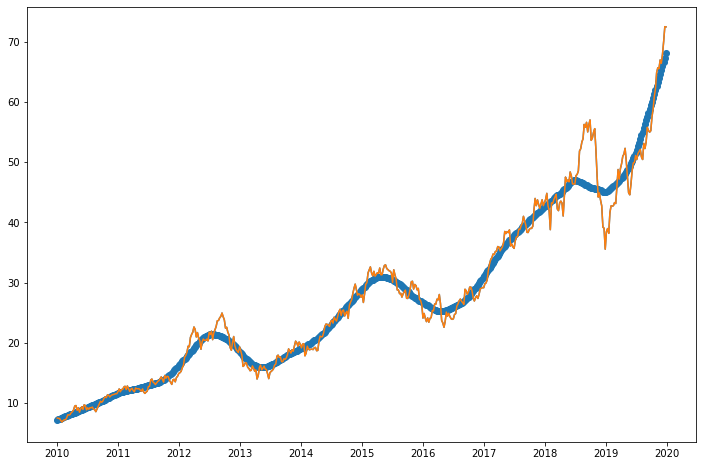

In [8]:
lowess_price = pd.Series(lowess_smoother(x=aapl_df.index, y=aapl_df['Close'], frac=0.1))
plt.plot(aapl_df['Close'])
aapl_df.replace(to_replace=aapl_df['Close'], value=lowess_price)
plt.plot(aapl_df['Close'])

#### Calculate arithmetic return

In [9]:
week_rt = (aapl_df['Close']/aapl_df['Close'].shift(1) - 1).rename('Weekly Return')
aapl_df = pd.concat([aapl_df, week_rt], axis=1)
year_rt = aapl_df['Close']/aapl_df['Close'].shift(52) - 1

#### Plot the prices and return

<AxesSubplot:xlabel='Date'>

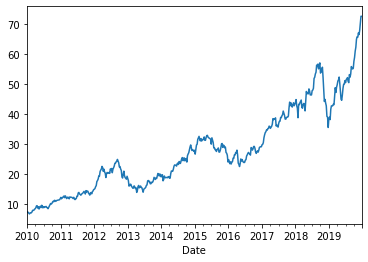

In [62]:
aapl_df['Close'].plot()  # weekly price of AAPL for the past 10 years

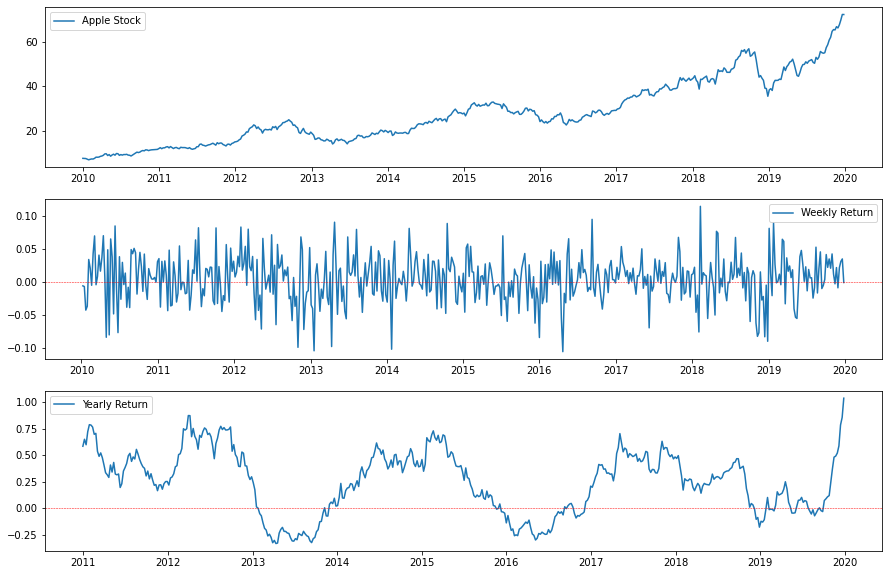

In [11]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(aapl_df['Close'])
ax[1].plot(week_rt)
ax[2].plot(year_rt)
ax[1].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[2].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[0].legend(['Apple Stock'])
ax[1].legend(['Weekly Return'])
ax[2].legend(['Yearly Return'])

### <a id='section2'></a> 2 $\bullet$ Exploratory Data Analysis

#### Histograms

Text(0.5, 1.0, 'AAPL weekly return')

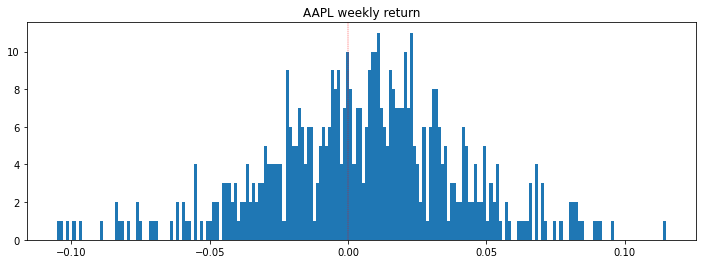

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(week_rt, bins=200)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Histogram with Kernel Density Estimate (KDE)

Text(0.5, 1.0, 'AAPL weekly return')

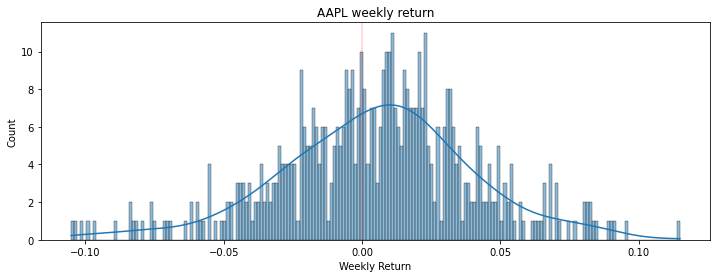

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(x=week_rt, kde=True, bins=200, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Empirical cumulative density function

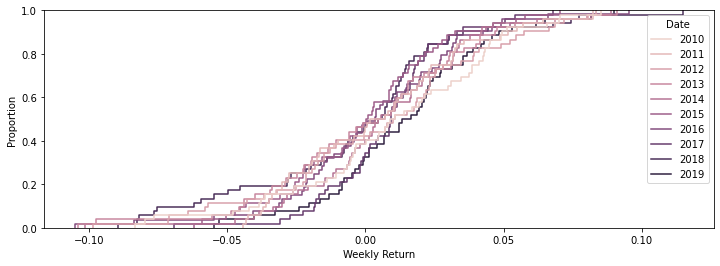

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
sns.ecdfplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, ax=ax);

#### Stacked histogram

Plot the histogram of the AAPL weekly returns, adding a hue for the different years and stacking the different years.

<AxesSubplot:xlabel='Weekly Return', ylabel='Count'>

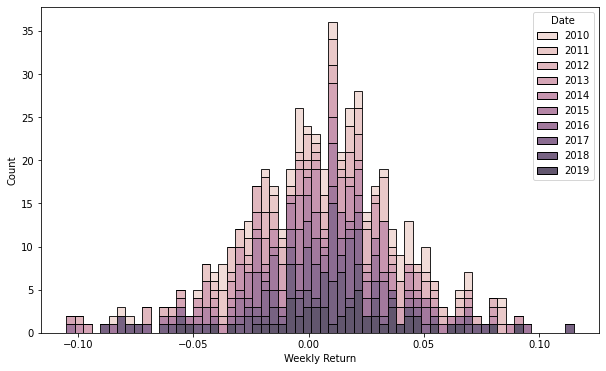

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, multiple='stack', bins=60, ax=ax)

#### Boxplot

<AxesSubplot:xlabel='Weekly Return', ylabel='Date'>

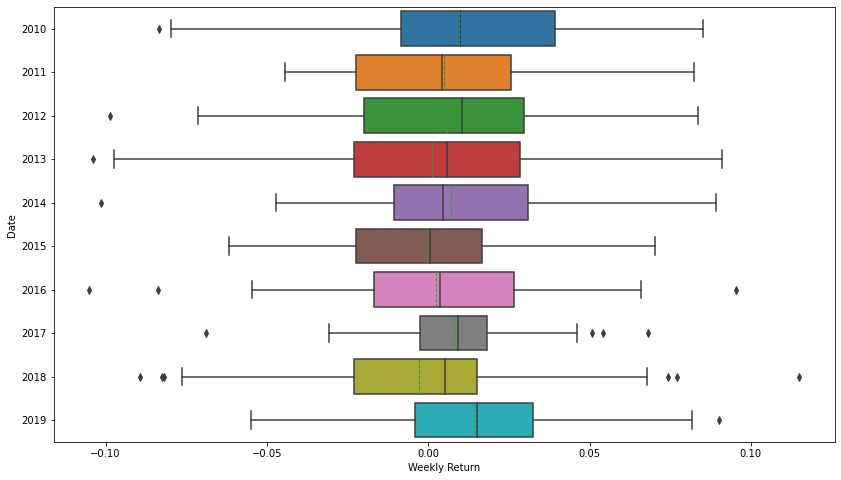

In [63]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x=week_rt, y=aapl_df.index.year, orient='h',
            showmeans=True, meanline=True, ax=ax)

#### Scatterplot

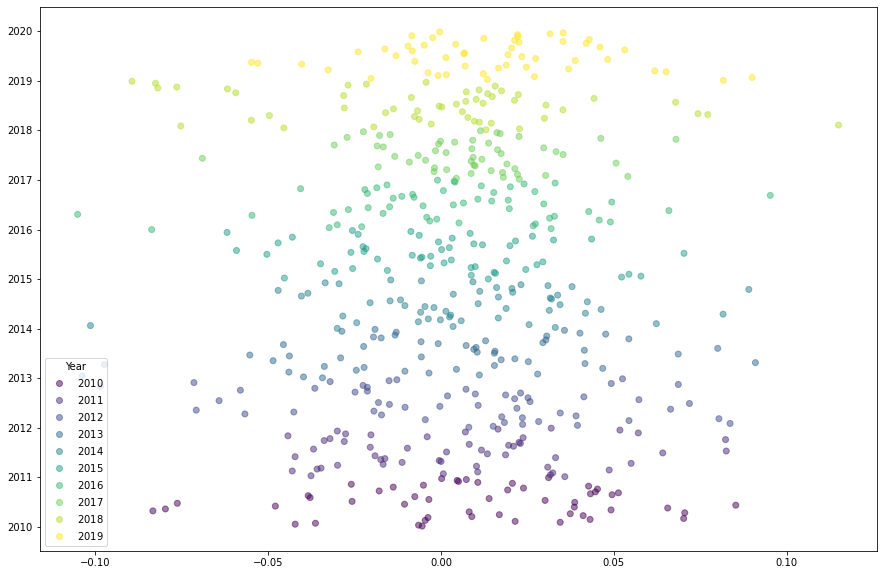

In [17]:
# plt.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
# plt.legend(aapl_df.index.year)
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
ax.legend(*scatter.legend_elements(),
                    loc='lower left', title='Year')

### <a id='section3'></a> 3 $\bullet$ Data testing

#### Test for stationarity

In [18]:
from statsmodels.tsa.api import adfuller, kpss, acf

Augmented Dickey-Fuller stationarity test (null hypothesis: non-stationarity)

In [19]:
def print_adf_test(x):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct',
                   'constant, and linear and quadratic trend': 'ctt',
                   'no constant, no trend': 'nc'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [20]:
adf_test_price = print_adf_test(aapl_df['Close'])  # ADF test for weekly price

,test statistic,p-value
constant only,1.3548,0.9969
constant and trend,-0.6129,0.9783
"constant, and linear and quadratic trend",-1.8329,0.8733
"no constant, no trend",2.8821,0.9996


p-value > 0.05, **we cannot reject the null hypothesis of non-stationarity**.

In [21]:
adf_test_rt = print_adf_test(week_rt.dropna())  # ADF test for weekly return

,test statistic,p-value
constant only,-22.8508,0.0
constant and trend,-22.8307,0.0
"constant, and linear and quadratic trend",-22.9014,0.0
"no constant, no trend",-22.4196,0.0


p-value < 0.001, reject the null hypothesis of non-stationarity. **The weekly return of AAPL is stationary.**

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (Null hypothesis: stationarity)

In [22]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [23]:
print_kpss_test(aapl_df['Close'])  # KPSS test for weekly price

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,3.0170,0.01
constant and trend,0.3682,0.01


,test statistic,p-value
constant only,3.017049,0.01
constant and trend,0.368155,0.01


p-value < 0.01, **we have 99% confidence to reject the null hypothesis of stationarity**.

In [24]:
print_kpss_test(week_rt.dropna())  # KPSS test for weekly return

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,0.0757,0.1
constant and trend,0.0710,0.1


,test statistic,p-value
constant only,0.075650,0.1
constant and trend,0.070976,0.1


p-value > 0.1, we cannot reject the null hypothesis of stationarity. **The weekly return is stationary.**

#### Test for autocorrelation

$\bullet$ Individual test

In practice, one need at least T ⩾ 50 (T is the number of observations) and h ⩽ T/4. In this case T = 1153, so h ⩽ 288.

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [26]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1])
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

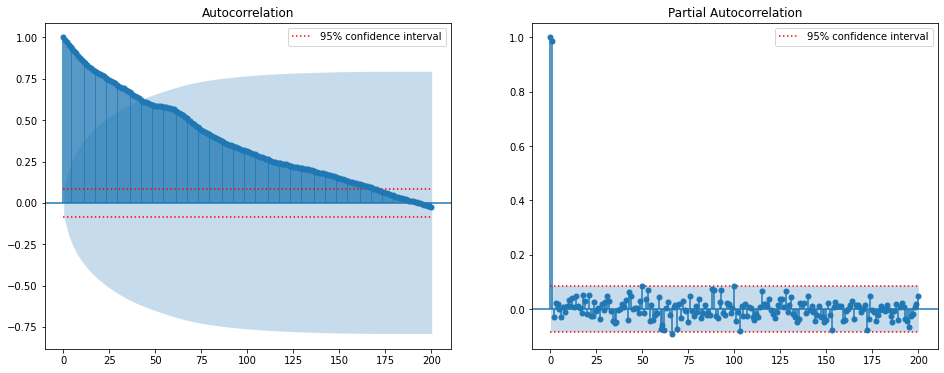

In [27]:
acf_plot_price = acf_pacf(aapl_df['Close'], lags=200)

As lag increases, the autocorrelation effect decreases; but clearly when the lags are small, the autocorrelation is strong. Because all the  For partial autocorrelation, the situation is much better, but when lag = 1 and when lag = 2, there are still a high autocorrelation effect. **We can conclude that the stock price of AAPL is not white noise.**

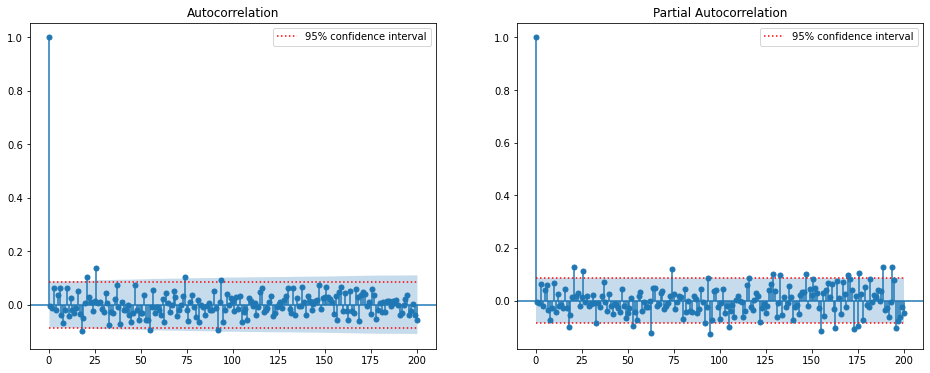

In [28]:
acf_plot_rt = acf_pacf(week_rt.dropna(), lags=200)

We can conclude that **weekly return is not a white noise.**

$\bullet$ Joint test: the Ljung–Box Q test

In [29]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [30]:
lags = np.array([1, 2, 3, 5, 7, 10, 20])
res1 = print_acf(aapl_df['Close'], lags)

,Q Statistic,p-value (%)
up to lag 1,510.23,0.0
up to lag 2,1006.28,0.0
up to lag 3,1489.03,0.0
up to lag 5,2417.29,0.0
up to lag 7,3296.01,0.0
up to lag 10,4526.64,0.0
up to lag 20,8089.38,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly price is not a white noise.**

In [31]:
res2 = print_acf(week_rt.dropna(), np.array([1, 3, 5, 10, 20, 25, 30]))

,Q Statistic,p-value (%)
up to lag 1,0.01,92.82
up to lag 3,2.22,52.73
up to lag 5,3.22,66.56
up to lag 10,10.75,37.75
up to lag 20,21.59,36.33
up to lag 25,28.46,28.71
up to lag 30,39.33,11.85


We cannot reject the null hypothesis that autocorrelation does not exist. So weekly return could potentially be whiete noise. **We should use weekly price for the linear model.**

### <a id='section4'></a> 4 $\bullet$ Fitting an ARMA model

$\bullet$ Selecting a model with information criteria 
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='nc'` no constant: long run mean is zero

In [32]:
from statsmodels.tsa import stattools

# Silence the warning
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [33]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = stattools.arma_order_select_ic(x, max_ar=max_ar, max_ma=max_ma, ic=['aic', 'bic'], trend=trend)
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [34]:
res = select_arma(aapl_df['Close'], max_ar=4, max_ma=4, trend='c')

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

AIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        4251.0  3592.2  3082.3  2903.4  2444.4
1        1534.6  1516.7  1516.8  1518.6  1518.0
2        1516.1  1523.2  1520.0  1519.9  1521.2
3        1530.1  1514.8  1519.7  1519.2  1522.4
4        1527.7  1519.4  1517.8  1522.4  1520.5

AIC selected order:  (3, 1)


BIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        4259.5  3605.0  3099.3  2924.6  2470.0
1        1547.3  1533.7  1538.1  1544.1  1547.8
2        1533.1  1544.5  1545.6  1549.7  1555.3
3        1551.4  1540.4  1549.5  1553.3  1560.8
4        1553.3  1549.2  1551.8  1560.8  1563.1

BIC selected order:  (2, 0)


Based on the result of BIC, we fit AR(2) model to the dataset

In [64]:
import statsmodels.tsa.arima.model as smt_arima
model = smt_arima.ARIMA(aapl_df['Close'], order=(2, 0, 0))  # ARMA function is deprecated

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [65]:
fitted_model = model.fit()
fitted_model.summary()

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -754.056
Date:                Mon, 31 May 2021   AIC                           1516.112
Time:                        20:57:02   BIC                           1533.142
Sample:                    01-01-2010   HQIC                          1522.782
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.9313     26.026      1.457      0.145     -13.079      88.942
ar.L1          1.1010      0.028     39.681      0.000       1.047       1.155
ar.L2         -0.1017      0.028     -3.662      0.000      -0.156      -0.047
sigma2         1.0391      0.041     25.136      0.000       0.958       1.120
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               189.10
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               5.58   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='section5'></a> 5 $\bullet$ Residual Analysis

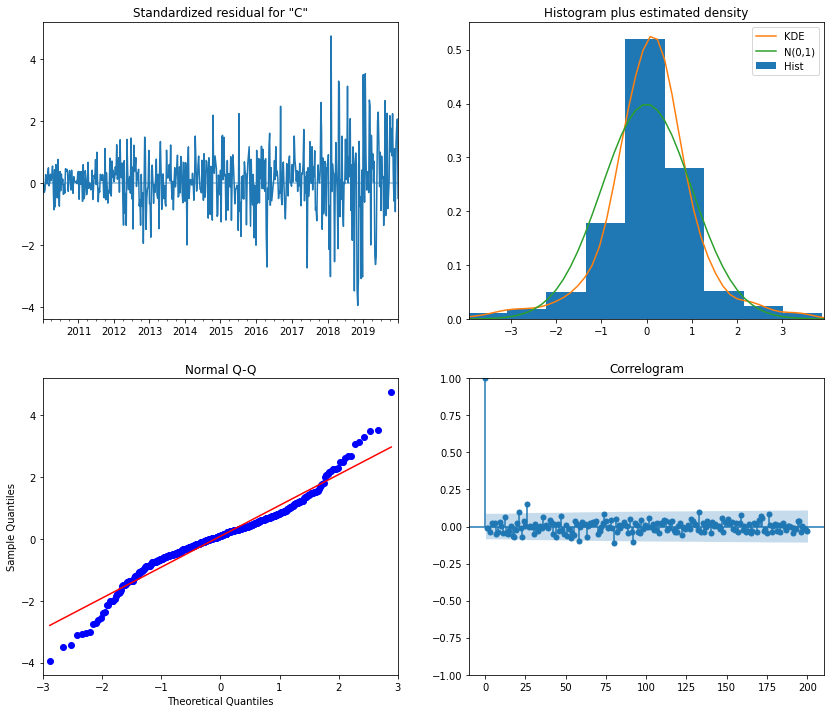

In [53]:
fig = fitted_model.plot_diagnostics(figsize=(14,12), lags=200)

We confirm the absence of autocorrelation seen in the Correlogram with the Ljung-Box Q Test.  
This proves that the ARMA model has captured most of the autocorrelation structure that is in the weekly price dataset.

In [54]:
res = print_acf(fitted_model.resid, lags)

,Q Statistic,p-value (%)
up to lag 1,0.04,83.63
up to lag 2,0.08,96.31
up to lag 3,0.87,83.22
up to lag 5,1.19,94.60
up to lag 7,2.49,92.76
up to lag 10,3.58,96.45
up to lag 20,14.33,81.34


p-value > 0.05, we cannot reject the null hypothesis of no autocorrelation.

### <a id='section6'></a> 6 $\bullet$ Prediction vs. Realized Values

In [73]:
forecast = fitted_model.get_forecast(steps=25)  # Predict values of one year starting from 2020-01-03
f = forecast.summary_frame()
f.tail()

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-05-22,71.900447,5.134339,61.837328,81.963565
2020-05-29,71.874503,5.254408,61.576053,82.172953
2020-06-05,71.848579,5.371617,61.320404,82.376754
2020-06-12,71.822675,5.486149,61.070021,82.575329
2020-06-19,71.796790,5.598169,60.824581,82.768999


Plot the predicted values

In [74]:
realized_value = yf.download(tickers='AAPL', start=min(f.index), end=max(f.index), interval='1wk')  # download the realized stock prices

[*********************100%***********************]  1 of 1 completed


In [ ]:
AR2_unconditional_mean = fitted_model.params['const']
AR2_unconditional_variance = fitted_model.params['sigma2'] / (1 - fitted_model.params['ar.L1'] ** 2)

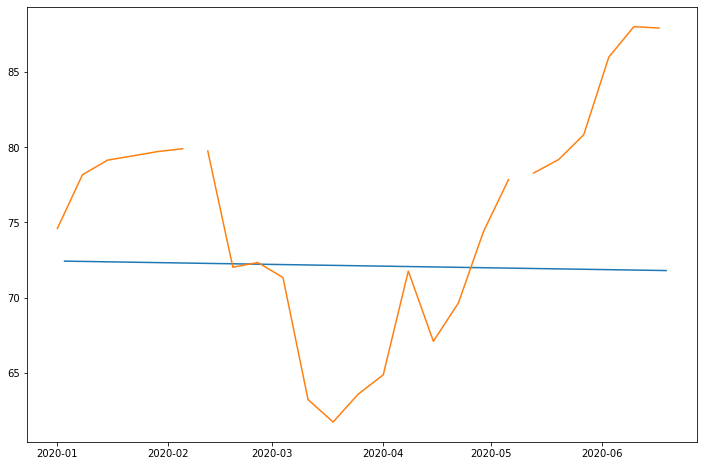

In [78]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(f['mean'])
ax.plot(realized_value['Close'])